# Unsupervised Learning: Clustering
Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [66]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from itertools import cycle

import math
import scipy.stats as stats
from matplotlib.mlab import PCA as mlabPCA
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.patches as mpatches

In [2]:
df = pd.read_csv('results2014.csv')
df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [4]:
df.head(2)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10


In [5]:
df.isnull().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

In [6]:
df.loc[(df['state'].isnull()) & (df["country"] == "USA")]

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k


## Data Cleaning
All the rows missing a state entry are for those who from outside the US. I'll fill in those with an out of country indicator.

In [7]:
# Remove hyphens from missing entries
df = df.replace(to_replace='-', value='')

# Convert checkpoints to numeric types
splits = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k' ]
for split in splits:
    df[split] = pd.to_numeric(df[split])

# Drop Columns name since we're not looking at individuals.
# Drop citizenship column since 96% of racers don't report their 
# citizenship rather their country of residence.
df = df.drop(columns = ['name', 'ctz'])

# Drop the one person who didn't say which city they're from (why are you like this?)
df = df.dropna(subset=['city'])

# Rows misisng states all belong to people who live outside of the US
# give them a new variable for out of USA residence for state
df['state'] = df['state'].fillna(value='ZZ')

In [8]:
# One hot endcode gender so that it's a binary
# for plotting and modeling
df = pd.get_dummies(df,columns=['gender'])

In [9]:
df = df.dropna()

## Exploratory Data Analysis

### Gender

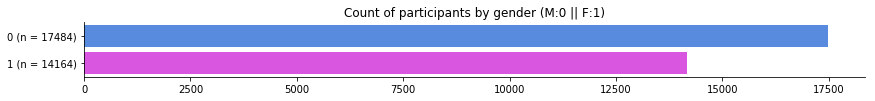

In [10]:
# Define the y labels for the visualization
gender_labels = ['{} (n = {})'.format(gender, df[df['gender_F'] == gender].shape[0]) for gender in df['gender_F'].unique()]
gender_colors = {0:'#4286f4', 1:'#ee40f7'} # gender

# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['gender_F'], palette=gender_colors)
sns.despine()
plt.title('Count of participants by gender (M:0 || F:1)')
plt.xlabel('')
plt.ylabel('')
plt.yticks([0,1], labels = gender_labels)
plt.show()

### Age Brackets
> The Boston marathon divides its qualifying times into 5 year age brackets (except 18-34), so those are what I'll use for feature engineering and visualization going forward. <br>
*For more information, see: https://www.baa.org/races/boston-marathon/enter/qualify/history-qualifying-times*

In [11]:
# Because the first and last bins aren't equal to the others, I'll have to manually bin them
age_bins= [18,35,40,45,50,55,60,65,70,75,80,(df['age'].max()+1)]

# Create a column for age groups
age_labels = ['18-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
df['age_groups'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

### The feature 'bib' is the number printed on a participant's bib. It contains information about a participant's start wave.
>Bib numbers indicate which wave of the race the participant was assigned to as well as what time of day they began the race. Participants whose bib began with F were assigned to the women's elite wave, while participants whose bib began with W were assigned to the push wheelchair elite wave. <br><br>
*For more information, refer to: http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm <br>
elite entries http://registration.baa.org/2014/cf/Public/iframe_EntryListsElite.cfm <br>
top finishers and special divisions http://registration.baa.org/2014/cf/Public/iframe_TopFinishers.htm*

<Figure size 1008x72 with 0 Axes>

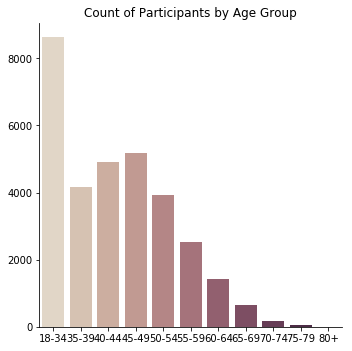

In [12]:
# Plot the figure
plt.figure(figsize=(14,1))
sns.catplot(x="age_groups", 
            kind="count", 
            palette="ch:.25", 
            data=df)
plt.title('Count of Participants by Age Group')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [13]:
# Remove letter from women and wheelchair racers
# To not mix the wheelchair athletes with the elite runners
# I gave them real large numbers starting with 4000.
df['bib'] = df['bib'].str.replace('W','4000')
df['bib'] = df['bib'].str.replace('F','1.')

#convert column to numeric type
df['bib'] = pd.to_numeric(df['bib'])

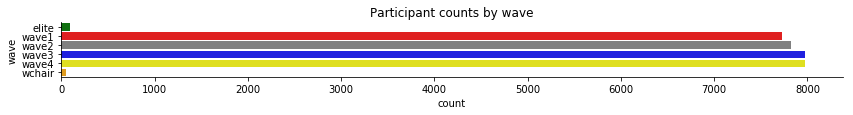

In [14]:
# bib numbers for each wave
wave_bins= [0,101,9000,18000,27000,40000,(df['bib'].max()+1)]

# Create a column for waves
wave_labels = ['elite', 'wave1', 'wave2', 'wave3', 'wave4', 'wchair']

# Create a wave column
df['wave'] = pd.cut(df['bib'], bins=wave_bins, labels=wave_labels, right=False)

# wave colors
wave_colors = ["green", "red", "grey", "blue", "yellow", "orange"]

# Plot the figure
plt.figure(figsize=(14,1))
sns.countplot(y=df['wave'], palette=wave_colors)
sns.despine()
plt.title('Participant counts by wave')
plt.show()

In [15]:
print('Number of Represented Countries: {}\n{}'.format(len(df['country'].unique()), df['country'].unique()))

print('\nNumber of Represented States: {}\n{}'.format(len(df['state'].unique()), df['state'].unique()))

Number of Represented Countries: 78
['JPN' 'KEN' 'RSA' 'ETH' 'SUI' 'USA' 'FRA' 'CAN' 'ESP' 'POL' 'RUS' 'BLR'
 'MAR' 'UKR' 'BRA' 'THA' 'CHN' 'ITA' 'GER' 'GBR' 'AUS' 'SWE' 'GRE' 'SLO'
 'IRL' 'KOR' 'ARG' 'COL' 'NED' 'ISR' 'CZE' 'NOR' 'CRC' 'MEX' 'GUA' 'SIN'
 'DEN' 'HUN' 'BEL' 'FIN' 'AUT' 'CHI' 'ISL' 'VEN' 'DOM' 'PER' 'HKG' 'SVK'
 'NZL' 'TPE' 'PHI' 'CAY' 'POR' 'UAE' 'IND' 'PAN' 'ROU' 'LUX' 'ESA' 'TRI'
 'MAS' 'VGB' 'EGY' 'BRN' 'EST' 'ECU' 'LIE' 'TUR' 'BOL' 'BAR' 'URU' 'QAT'
 'INA' 'BER' 'TAN' 'BAH' 'CRO' 'ZIM']

Number of Represented States: 69
['ZZ' 'CA' 'ON' 'MI' 'QC' 'IL' 'OR' 'AZ' 'CO' 'VA' 'GA' 'NJ' 'ME' 'MA'
 'UT' 'NY' 'MO' 'RI' 'NH' 'MT' 'KY' 'FL' 'TN' 'AB' 'WA' 'WI' 'DC' 'PA'
 'OH' 'IN' 'NS' 'MD' 'IA' 'MN' 'CT' 'SD' 'TX' 'DE' 'LA' 'NC' 'OK' 'NV'
 'AL' 'KS' 'NE' 'MB' 'HI' 'AK' 'NM' 'BC' 'VT' 'ID' 'SC' 'WV' 'PE' 'ND'
 'MS' 'AR' 'SK' 'NT' 'PR' 'WY' 'NB' 'YT' 'NL' 'AE' 'AA' 'AP' 'GU']


### Demographics Between Features and Checkpoints


#### Gender & Checkpoints

C:\Users\AES\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


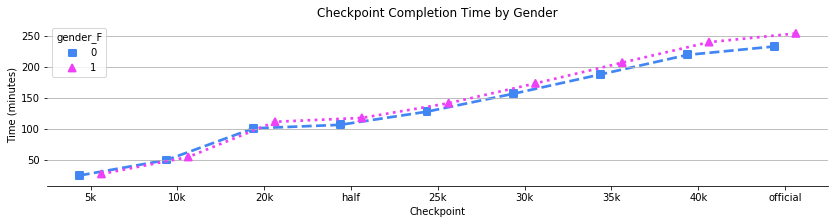

In [16]:
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoints',
                              value_name='time',
                              id_vars=['gender_F'])

plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoints',
            y='time',
            hue='gender_F',
            markers=[',','^'],
            linestyles=['--', ':'],
            palette=gender_colors,
            ci=95,
            orient="v",
            dodge=0.25)

ax.grid(axis='y')
sns.despine(left=True)

plt.title('Checkpoint Completion Time by Gender')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [17]:
f_avg = round(df[df['gender_F'] == 1]['official'].mean(),2)
m_avg = round(df[df['gender_F'] == 0]['official'].mean(),2)

print('The average women\'s finish time was {} minutes \nThe average men\'s finish time was {} minutes'.format(f_avg, m_avg))

The average women's finish time was 253.55 minutes 
The average men's finish time was 232.55 minutes


#### Countries & Checkpoints

It would be too congested plotting all 78 represented countries, so I focused on the 10 countries with the top 10 finishing times, and grouped the remaining 68 countries.

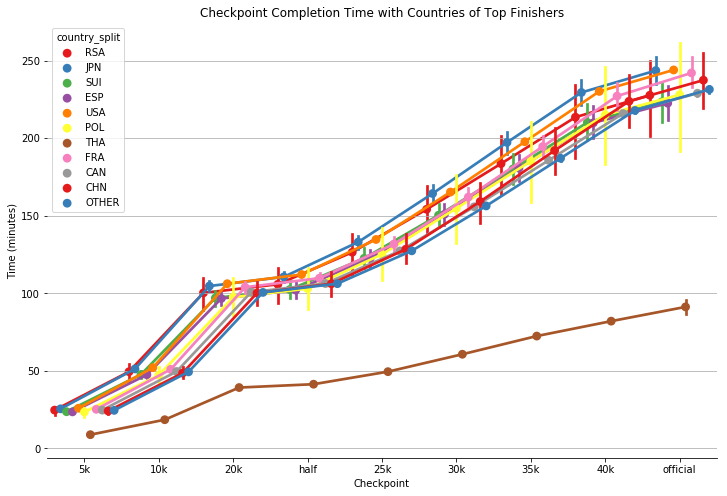

In [18]:
# Compare top 10 countries with elite finishers to all other countries
other_countries = df.groupby('country')['official'].min().sort_values(ascending=True)[10:]
df['country_split'] = df['country'].apply(lambda x: np.where(x in other_countries, 'OTHER', x))

stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoints',
                              value_name='time',
                              id_vars=['country_split'])

plt.figure(figsize=(12,8))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoints',
            y='time',
            hue='country_split',
            hue_order=['RSA', 'JPN', 'SUI', 'ESP', 'USA', 'POL', 'THA', 'FRA', 'CAN', 'CHN', 'OTHER'],
            palette=sns.color_palette('Set1').as_hex(),
            ci=95,
            orient="v",
            dodge=0.8)

ax.grid(axis='y')
sns.despine(left=True)

plt.title('Checkpoint Completion Time with Countries of Top Finishers')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [19]:
# Define a function to streamline descriptive statistic retrieval
def get_descriptives(column, category):
    c_n = df[df[column] == category]['official'].shape[0]
    c_avg = round(df[df[column] == category]['official'].mean(),2)  
    print('In 2014 there were {} {} athletes\nWho on average finished the race in'
          ' {} minutes\n'.format(c_n, category, c_avg))    

# Print some descriptive statistics to provide further information
for country in ['RSA', 'JPN', 'SUI', 'ESP', 'USA', 'POL', 'THA', 'FRA', 'CAN', 'CHN']:
    get_descriptives('country', country)

In 2014 there were 19 RSA athletes
Who on average finished the race in 227.63 minutes

In 2014 there were 172 JPN athletes
Who on average finished the race in 243.55 minutes

In 2014 there were 62 SUI athletes
Who on average finished the race in 223.34 minutes

In 2014 there were 87 ESP athletes
Who on average finished the race in 222.51 minutes

In 2014 there were 26939 USA athletes
Who on average finished the race in 243.93 minutes

In 2014 there were 15 POL athletes
Who on average finished the race in 227.95 minutes

In 2014 there were 2 THA athletes
Who on average finished the race in 91.2 minutes

In 2014 there were 113 FRA athletes
Who on average finished the race in 242.0 minutes

In 2014 there were 2164 CAN athletes
Who on average finished the race in 228.92 minutes

In 2014 there were 42 CHN athletes
Who on average finished the race in 237.35 minutes



#### Checkpoints & Waves

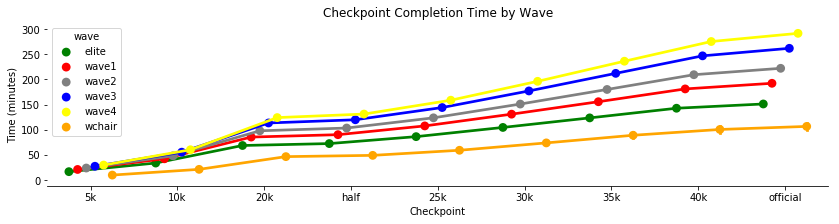

In [20]:
# Make the checkpoint completion times tidy for easier visualization
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['wave'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,3))
ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='wave',
            palette=wave_colors,
            ci=95,
            orient="v",
            dodge=0.5)

sns.despine(left=True)

plt.title('Checkpoint Completion Time by Wave')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

plt.show()

In [21]:
# Print some descriptive statistics to provide further information
for wave in df['wave'].unique():
    get_descriptives('wave', wave)

In 2014 there were 53 wchair athletes
Who on average finished the race in 106.71 minutes

In 2014 there were 94 elite athletes
Who on average finished the race in 151.26 minutes

In 2014 there were 7723 wave1 athletes
Who on average finished the race in 192.34 minutes

In 2014 there were 7825 wave2 athletes
Who on average finished the race in 222.1 minutes

In 2014 there were 7976 wave3 athletes
Who on average finished the race in 261.81 minutes

In 2014 there were 7977 wave4 athletes
Who on average finished the race in 291.57 minutes



These results make sense. Wheelchair and elite racers finished the fastest with each subsequent wave finishing slightly slower than the group before it.

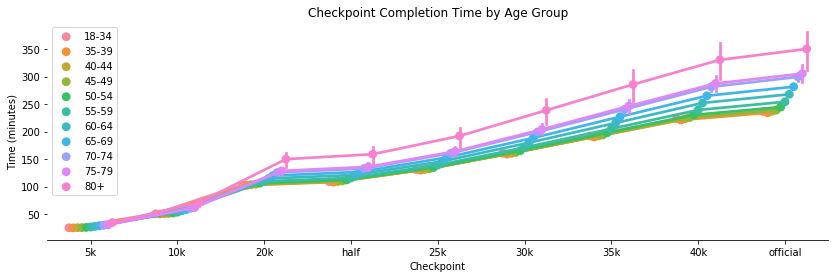

In [22]:
stacked_checkpoints = pd.melt(df, 
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'], 
                              var_name='checkpoint', 
                              value_name='time', 
                              id_vars=['age_groups'])

# Visualize checkpoint completion time by wave
plt.figure(figsize=(14,4))

ax = sns.pointplot(data=stacked_checkpoints,
            x='checkpoint',
            y='time',
            hue='age_groups',
            ci=95,
            orient="v",
            dodge=0.5)

sns.despine(left=True)

plt.title('Checkpoint Completion Time by Age Group') 
plt.ylabel('Time (minutes)') 
plt.xlabel('Checkpoint')
plt.legend(loc='upper left')
plt.show()

In [23]:
# Print some descriptive statistics to provide further information
for group in df['age_groups'].unique():
    get_descriptives('age_groups', group)

In 2014 there were 5175 45-49 athletes
Who on average finished the race in 239.17 minutes

In 2014 there were 8626 18-34 athletes
Who on average finished the race in 236.67 minutes

In 2014 there were 4922 40-44 athletes
Who on average finished the race in 236.93 minutes

In 2014 there were 4178 35-39 athletes
Who on average finished the race in 234.17 minutes

In 2014 there were 3921 50-54 athletes
Who on average finished the race in 244.53 minutes

In 2014 there were 2519 55-59 athletes
Who on average finished the race in 254.16 minutes

In 2014 there were 1434 60-64 athletes
Who on average finished the race in 267.79 minutes

In 2014 there were 646 65-69 athletes
Who on average finished the race in 281.57 minutes

In 2014 there were 175 70-74 athletes
Who on average finished the race in 299.4 minutes

In 2014 there were 44 75-79 athletes
Who on average finished the race in 305.42 minutes

In 2014 there were 8 80+ athletes
Who on average finished the race in 350.22 minutes



There were slight but noticeable differences between the average times for each age group. Three age groups between the ages of 18 to 49 and their average times are within just 3 minutes of each other.


### Clustering

In [24]:
# Create a new dataframe for features
features = pd.DataFrame()

# Add country
# features['country'] = df['country'] # only keep if one hot encoding all countries

# Add age
features['age'] = df['age']

# Add gender to the feature set.
features['is_female'] = df['gender_F']

# Add countries with top 10 finishers - as binary features
for country in ['RSA', 'JPN', 'SUI', 'ESP', 'USA', 'POL', 'THA', 'FRA', 'CAN', 'CHN', 'OTHER']:
    features[country] = np.where(df['country'] == country, 1, 0)

# Add waves as binary columns.
for wave in df['wave'].unique():
    features[wave] = np.where(df['wave'] == wave, 1, 0)
    
# Rescale and add overall finishing position.
features['overall'] = df['overall']

# Rescale and add division finishing position.
features['division'] = df['division']

# Rescale and add gender division finishing position.
features['genderdiv'] = df['genderdiv']

# Add checkpoint times.
for col in ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official']:
    features[col] = df[col]
    
features.head(3)

,age,is_female,RSA,JPN,SUI,ESP,USA,POL,THA,FRA,...,genderdiv,5k,10k,20k,half,25k,30k,35k,40k,official
0,47,0,0,1,0,0,0,0,0,0,...,8,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25
1,33,1,0,0,0,0,0,0,0,0,...,1,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95
2,41,0,1,0,0,0,0,0,0,0,...,1,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60


>I won't be using k-means or spectral clustering because I'm not certain that the groupings I made prior would be the best for dertermining official times, therefore being unsure of how many clusters there should be. I'm not using affinity propagation because it's too computationally expensive. <br><br>
I'm going to use PCA first and then run DBSCAN, then I'll run mean-shift clustering. <br>

### PCA

In [25]:
X = features

# First center and scale the data
scaled_data = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=list(features))
X_scaled.head(2)

C:\Users\AES\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\AES\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,age,is_female,RSA,JPN,SUI,ESP,USA,POL,THA,FRA,...,genderdiv,5k,10k,20k,half,25k,30k,35k,40k,official
0,0.408448,-0.900062,-0.024509,13.527749,-0.044305,-0.052503,-2.391808,-0.021776,-0.00795,-0.059861,...,-1.689130,-4.189011,-3.933261,-3.532013,-3.520651,-3.359660,-3.183865,-3.056622,-3.073577,-3.082125
1,-0.830533,1.111034,-0.024509,-0.073922,-0.044305,-0.052503,-2.391808,-0.021776,-0.00795,-0.059861,...,-1.690609,-2.243754,-2.187012,-2.061201,-2.055593,-2.000331,-1.963104,-1.953740,-1.998785,-2.025922


In [26]:
# Utilizing Two Components
# Perform PCA for graphing purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_1 = [x[0] for x in X_pca]
pca_2 = [x[1] for x in X_pca]

X_pca

array([[-10.94759206,   2.30820441],
       [ -6.99945229,   0.15577609],
       [-11.26484141,   1.09075247],
       ...,
       [  3.33699795,  -2.59566457],
       [  4.7415971 ,  -1.85095021],
       [  0.46997789,  -0.2286657 ]])

### DBSCAN

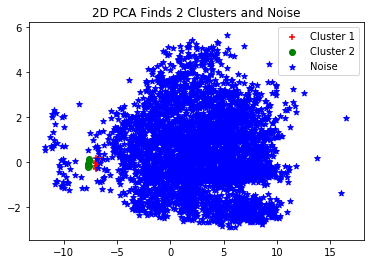

In [29]:
from sklearn.cluster import DBSCAN

# Declaring Model (vanilla DBS)
dbscan = DBSCAN()

# Fitting
db = dbscan.fit(X_scaled)

### 2D PCA on DBScan
####################
# Plot based on Class
for i in range(0, X_pca.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='b', marker='*')

plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Noise'])
plt.title('2D PCA Finds 2 Clusters and Noise')
plt.show()

C:\Users\AES\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\AES\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Estimated number of clusters: 62
Estimated number of noise points: 15778
Homogeneity: 0.173
Completeness: 1.000
V-measure: 0.295
Adjusted Rand Index: 0.000


C:\Users\AES\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Adjusted Mutual Information: 0.000
Silhouette Coefficient: -0.207


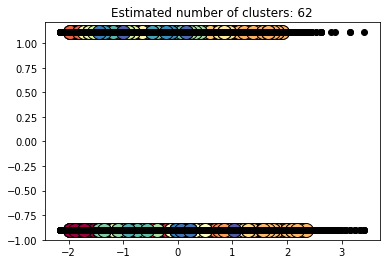

In [33]:
### DBSCAN and Evaluation
#########################

# Features and Target data
X2 = X_scaled.drop(['overall'], axis=1).values
y = X_scaled['overall'].values
# Standardizing the features
X2 = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

### DBSCAN Evaluation
#####################
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X2, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

DBSCAN did a very poor job at picking up clusters. It attributed most datapoints to being noise, and it's sihouette score suggested the clustering is bad (if the visualization wasn't enough). I would have to utilize some sort of iteration to find the best parameters for it, which could take quite some time. <br>

### Mean Shift

C:\Users\AES\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\AES\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


number of estimated clusters : 10


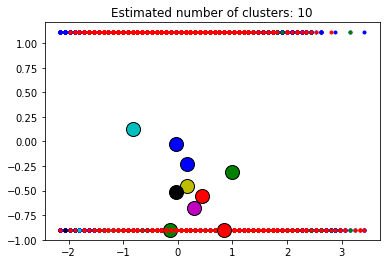

In [42]:
# Scale data and create separate dataframe
X = features
# First center and scale the data
scaled_data = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(scaled_data, columns=list(features))

# Features and Target data
X = X_scaled.drop(['overall'], axis=1).values
y = X_scaled['overall'].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(ms_labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
# colors = cycle(["green", "red", "grey", "blue", "yellow", "orange", "cyan", "purple", "black", "pink"])
for k, col in zip(range(n_clusters_), colors):
    my_members = ms_labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Visualizing the Clusters (PCA 2 main features)

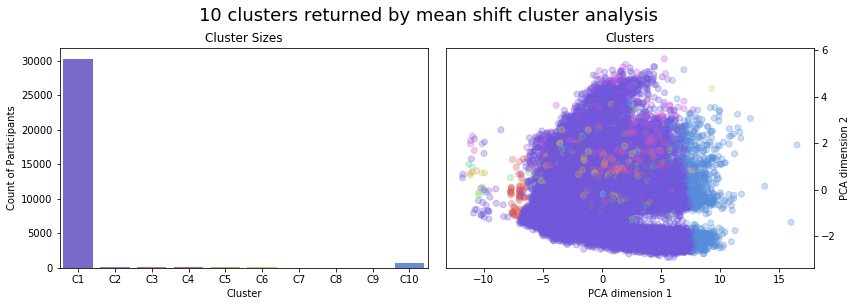

In [52]:
import matplotlib.colors as mpcol

# Add the clusters to the dataframes
features['cluster'] = ms_labels + 1
df['cluster'] = ms_labels + 1

# Create a dictionary to hold palettes for features and variables
palettes = {}

# Set the cluster palette
palettes['clust_rgb'] = sns.hls_palette(10, h=.7).as_hex()
palettes['clust_cmap'] = mpcol.ListedColormap(palettes['clust_rgb'], name='my_name')


plt.figure(figsize=(12,4))

# Create a plot that'll do double duty by labeling the clusters by color & describing their sizes
ax1 = plt.subplot(121)
sns.countplot(x=features['cluster'],
              palette=sns.color_palette(palettes['clust_rgb']))

plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Count of Participants')
cluster_labels = ['C{}'.format(x) for x in range(1,11)]
ax1.set_xticklabels(cluster_labels)

# Visualize the blobs
ax2 = plt.subplot(122)
plt.scatter(x=pca_1,
            y=pca_2,
            c=features['cluster'],
            cmap=palettes['clust_cmap'],
            alpha=0.3)
plt.title('Clusters')
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")


plt.suptitle('{} clusters returned by mean shift cluster analysis'.format(len(set(ms_labels))), fontsize=18, y=1.05)

plt.tight_layout()
plt.show()

### Metrics for Mean Shift
The ground truth is unknown, so silhouette coefficient is the main focus

In [53]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

counter = 0
for sample in [X1, X2, X3, X4]:
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(sample)
    labels = model.labels_
    counter += 1
    print('Silhouette coefficient for sample {}: {}'.format(counter, 
                                                            round(metrics.silhouette_score(sample, 
                                                                                           labels, 
                                                                                           metric='euclidean'),4)))

Silhouette coefficient for sample 1: 0.3951
Silhouette coefficient for sample 2: 0.6217
Silhouette coefficient for sample 3: 0.6346
Silhouette coefficient for sample 4: 0.648


Even witht he first split being off, these scores are pretty consistent across the sample splits meaning my model is consistently producing clusters with points that are closer to each other than they are to other datapoints. Not only are the scores consistent, they're positive, making them much better than the DBSCAN model. <br>
That feels like solid ground to move forward on.

### Visualizing Cluster Demographics

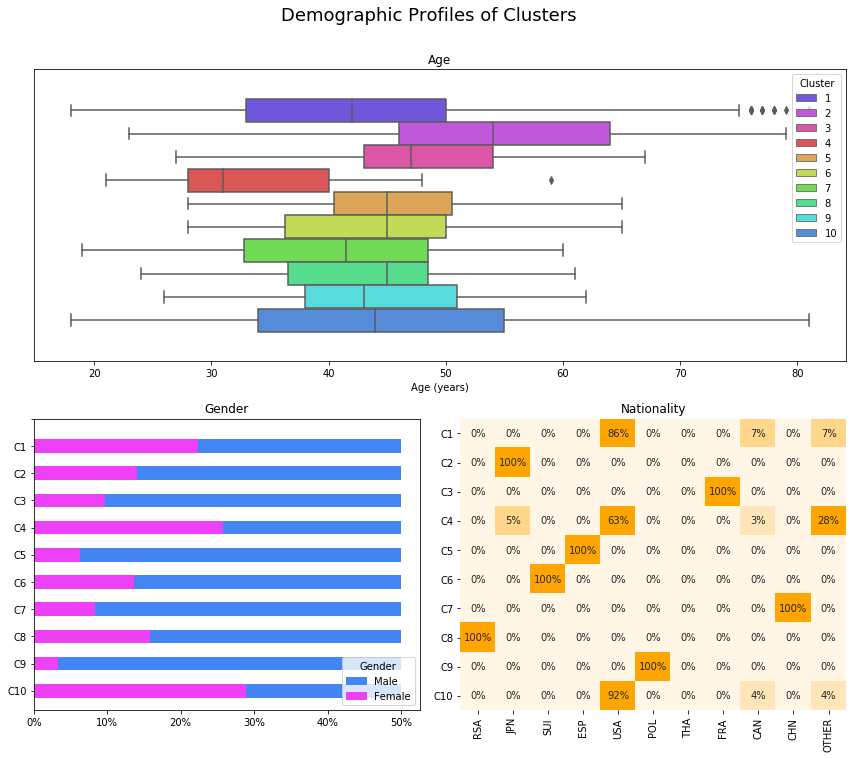

In [65]:
# df['cluster'] = ms_labels + 1

# Plot a figure summarizing demographics by cluster
plt.figure(figsize=(12,10))


### Age ###
###########
features['y'] = 1 # Add a dummy column for plotting in-place

ax1 = plt.subplot(211)
sns.boxplot(y='y',
            x='age',
            data=features,
            hue='cluster',
            palette=sns.color_palette(palettes['clust_rgb']),
            orient='h',
           saturation=1)

ax1.axes.get_yaxis().set_visible(False)

plt.title('Age')
plt.xlabel('Age (years)')
plt.legend(loc="upper right",
           title='Cluster')

### Gender
###########
ax2 = plt.subplot(223)
for cluster in np.arange(11):
    f_percent = features[features['cluster'] == cluster]['is_female'].mean()
    m_percent = 1 - features[features['cluster'] == cluster]['is_female'].mean()
    f_std = features[features['cluster'] == cluster]['is_female'].std()
    m_std = 1 - features[features['cluster'] == cluster]['is_female'].std()    
    
    p1 = plt.barh(cluster, f_percent, 0.5, color=gender_colors[1])
    p2 = plt.barh(cluster, m_percent, 0.5, left=f_percent, color=gender_colors[0])

plt.gca().invert_yaxis()
plt.yticks(np.arange(0, 11, 1))
ax2.set_yticklabels([''] + cluster_labels)
ax2.set_xticklabels(['{}%'.format(tick) for tick in np.arange(0,120,10)])

gender_legend = [mpatches.Patch(color=gender_colors[0], label='Male'),
                 mpatches.Patch(color=gender_colors[1], label='Female')]

plt.legend(handles=gender_legend,
           loc="lower right",
           title='Gender')
plt.title('Gender')


### Nationality
################

# Define a list of countries and shape the data for visualization
countries = ['RSA', 'JPN', 'SUI', 'ESP', 'USA', 'POL', 'THA', 'FRA', 'CAN', 'CHN', 'OTHER']
cntry_data = {}
for cluster in np.arange(1,11):
    cntry_data[cluster] = [(df[(df['cluster'] == cluster) & (df['country_split'] == country)]['country_split'].count())
                          /df[df['cluster'] == cluster].shape[0] for country in countries]
# Visualize the data
ax3 = plt.subplot(224)
sns.heatmap(pd.DataFrame(cntry_data, index=countries).transpose(), 
                 annot=True,
                 fmt=".0%",
                 cmap=sns.light_palette("orange"),
                 cbar=False,
                 vmin=0, 
                 vmax=0.15)

plt.yticks(rotation=0) 
cluster_labels = ['C{}'.format(x) for x in range(1,11)]
ax3.set_yticklabels(cluster_labels)
plt.title('Nationality')


# Define overall aesthetics and plot.
plt.suptitle('Demographic Profiles of Clusters',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

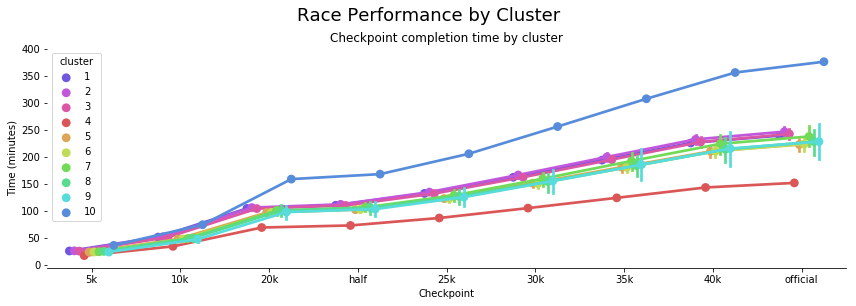

In [57]:
# Plot a figure summarizing race performance across clusters
plt.figure(figsize=(12,4))

### Checkpoints

# Tidy the data for easier visualization.
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['cluster'])

# Visualize checkpoint completion time by wave
sns.pointplot(data=stacked_checkpoints,
              x='checkpoint',
              y='time',
              hue='cluster',
              palette=sns.color_palette(palettes['clust_rgb']),
              ci=95,
              orient="v",
              dodge=0.5)

sns.despine(left=True)
ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

plt.title('Checkpoint completion time by cluster')
plt.ylabel('Time (minutes)')
plt.xlabel('Checkpoint')

lg = ax1.legend(title='Clusters', markerscale=2, fontsize=12)
title = lg.get_title()
title.set_fontsize(12)

# Name and show the overall plot.
plt.suptitle('Race Performance by Cluster',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

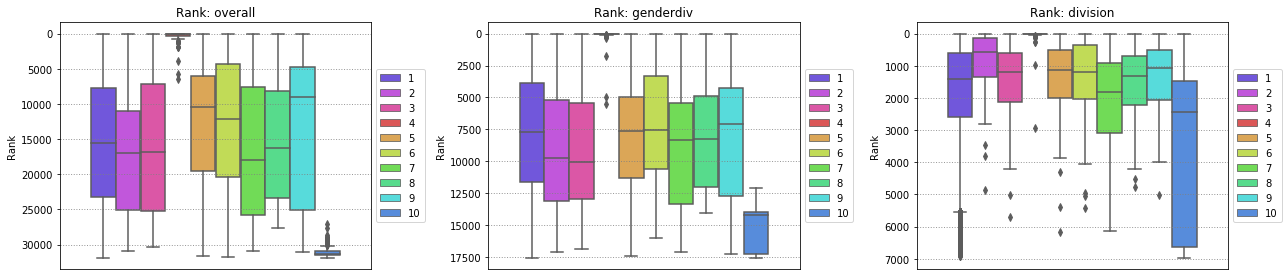

In [61]:
### Rankings

# Tidy the data for easier visualization.
stacked_divisions = pd.melt(df,
                            value_vars=['overall', 'division', 'genderdiv'],
                            var_name='division',
                            value_name='rank',
                            id_vars=['cluster'])

plt.figure(figsize=(18,4))
stacked_divisions['y'] = 1 # Add a dummy column for plotting in-place.

# Iterate through the division rankings and plot them
for idx, division in enumerate(['overall', 'genderdiv', 'division']):
    ax = plt.subplot(1,3,idx+1)    

    sns.boxplot(x='y',
                y='rank',
                data=stacked_divisions[stacked_divisions['division'] == division],
                hue='cluster',
                palette=sns.color_palette(palettes['clust_rgb']),
                orient='v',
                saturation=1)
    
#     ax.legend_.remove()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xticklabels('')
    ax.axes.get_xaxis().set_visible(False)
    plt.ylabel('')
    
    ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
    plt.gca().invert_yaxis() # Invert the plot so that higher ranks appear near the top.

    plt.title('Rank: {}'.format(division))
    plt.ylabel('Rank')
    
plt.tight_layout()
plt.show()

### Cluster Summaries
**Notable Clusters:**
Clusters 1, 4, and 10 were the most comprehensive clusters. Cluster 1 was pretty much an average of all racers. Cluster 4 was a great representation of the wheelchair division, but because of the fast times some of the elite racers may be mixed in. Lastly, cluster 10 was a great representation of the 80+ racers. A full breakdown is below. <br>

**Cluster 1:** Everybody (avg) Fairly representative of males and females. Picked up on US, Canada and other countries. Encompasses almost all ages, checkpoint average (of everyone), and looks at most ranks. <br>
**Cluster 2:** Japan. Fastest Runner per division. Ranked at the top. <br>
**Cluster 3:** The French. Male early 30s runners. <br>
**Cluster 4:** This is definitely a good representation of the wheelchair division. If you look at overall race performance, it follows the same pattern as the one I create manually. Another Indicator is rank. They had significantly fewer racers with bib numbers that made their division stand out. <br>
**Cluster 5:** Spain. Elite / Wave 1 <br>
**Cluster 6:** Switzerland Elite/Wave 1 (good mix of men and women). <br>
**Cluster 7:** China. Dominantly men. On average the slowest ranked racers.<br>
**Cluster 8:** Russia. More men than women racers, and finish closer to the back of their divisions.<br>
**Cluster 9:** Poland. Male dominated. Late 20s to early 60s. <br>
**Cluster 10:** These are our older and slower racers. Once again they follow the same checkpoint patterns as those in the 80+ age groups. Then looking at their rankings, they tend to finish slower than the rest of the groups. <br>

*Future edits, change country to being US versus everyone else combined (binary)*
